In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib notebook

# Checking is the times output is the same as the scale to years output we get from the analysis above

In [6]:
df_times = pd.read_csv("/Users/eniaxhakaj/Github/consistent-trees/times_array_output_2.txt")


scale_factor_ct = df_times["scale_factor"]
times_ct = df_times[" time"]

sf_set = np.unique(scale_factor_ct)

# print sf_set
# print "what are you doing???"
# print scale_factor_ct[:10]
# list(df_sorted)

# plot scale factor vs time 
times_set = []
same_sf = []
same_t = []

for sf in sf_set: 

    # where is this sf in the scale factor full array we got from the perl code
    idx_sf = np.where(scale_factor_ct == sf)[0]
    
    # which are the times for that array?
    same_t = times_ct[idx_sf]
    
    # Use the median as your represeantitve
    times_set.append(np.mean(same_t))
    
print len(times_set)

192


In [7]:
STEPS = 1024 
omega_0 = 0.3 #// Matter density
t_0 = 0       # // Time now (in Hubble time units).
times = np.zeros(STEPS+1)
H_CONV = 9.77813952e9/0.7
exact_t0_conv = 0



def init_time_table(Om, h0):
    
    a = 1
    omega_0 = Om
    H_CONV = 9.77813952e9/h0 # // 1/(1 km/s/Mpc) in years

    times[STEPS] = t_0
    exact_t0_conv = exact_scale_to_time(1.0)
    
    for i in range(1, STEPS):
        a = 1.0-i/float(STEPS)
        times[STEPS-i] = exact_scale_to_time(a)
    
    return 



def _exact_time_to_scale(t):
    
    m = np.sinh(1.5*t*np.sqrt(1.0-omega_0))
    
    return np.power(omega_0*m*m/(1.0-omega_0), 1.0/3.0)


def exact_scale_to_time(scale):
    
    t = scale
    a = _exact_time_to_scale(t)
    dt = scale/10.0
    count = 0
    
    while (abs(a-scale)>1e-7 and (count < 10)):
        count += 1
        a2 = _exact_time_to_scale(t+dt)
        move = (scale-a)*(dt)/(a2-a)
        t += move
        a = _exact_time_to_scale(t)

        if move/10.0 < 0.5*dt:
            dt = move/10.0
        else:
            dt /= 2.0
        
    return t-exact_t0_conv



# // Linearly interpolate between calculated values.

def scale_to_time(scale):

    s = scale
    l = (int)(s*STEPS)
    f = s*STEPS - l
    
    if (scale > 1):
        return exact_scale_to_time(scale)
    if (scale < 0):
        return times[0]
    
    return (times[l]+f*(times[l+1]-times[l]))


def scale_to_years(scale):
    return (scale_to_time(scale)*H_CONV);


init_time_table(0.27, 0.7)



<IPython.core.display.Javascript object>


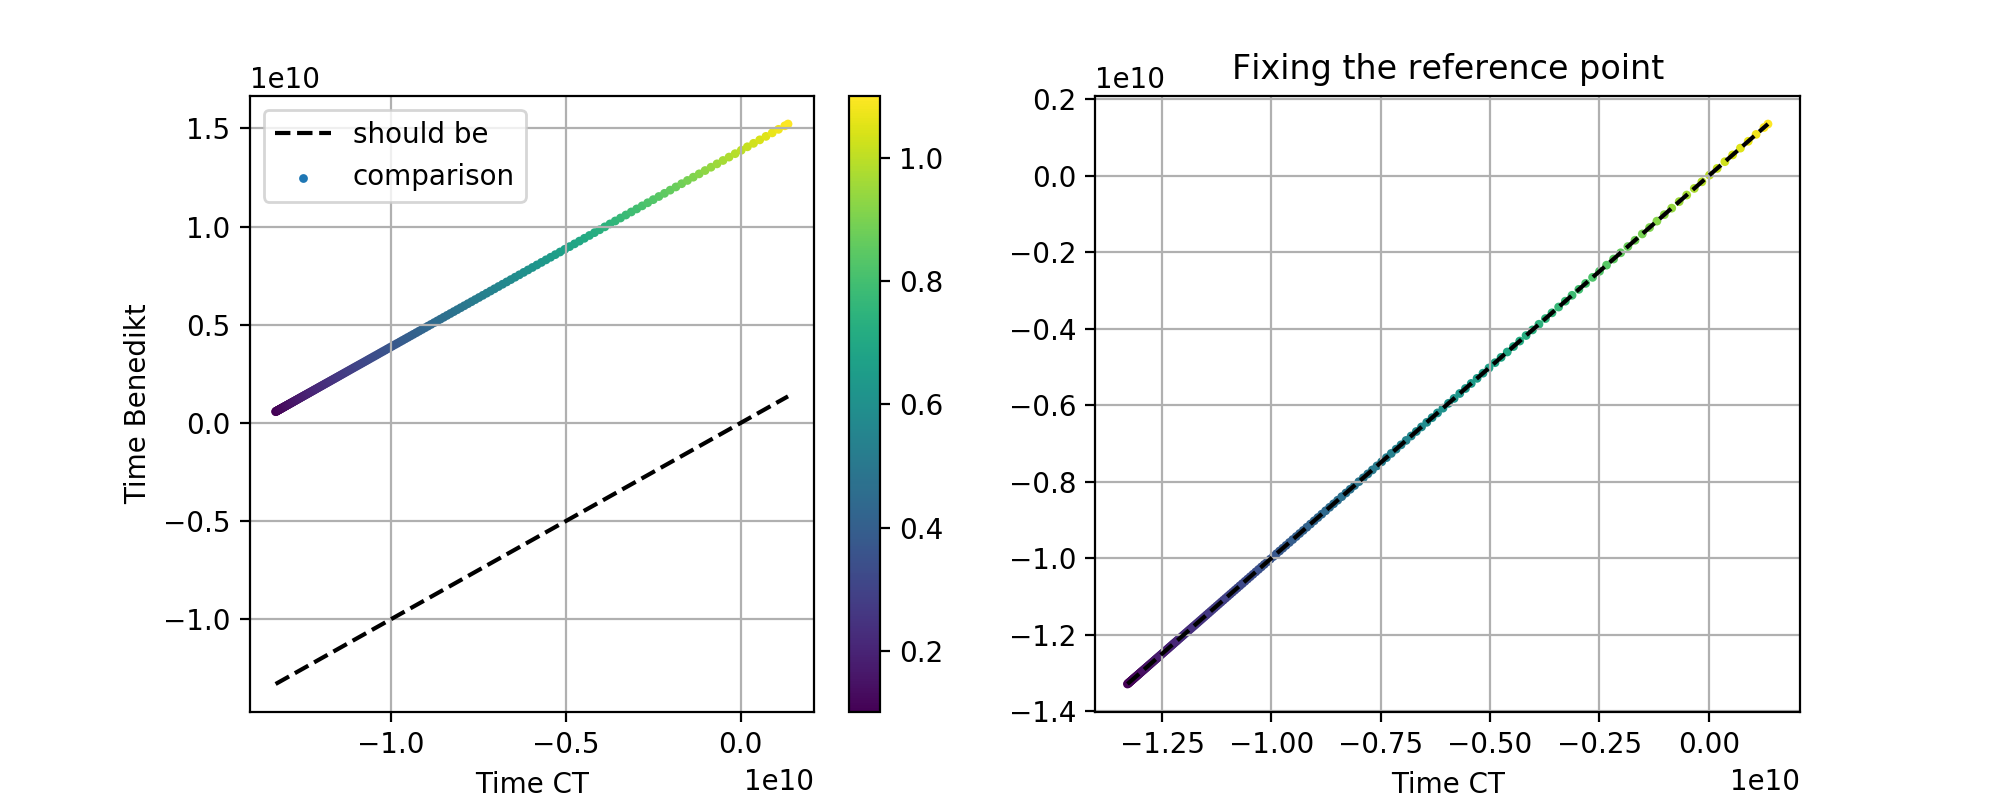

In [16]:
time_b = []
from colossus.cosmology import cosmology

cosmo = cosmology.setCosmology('bolshoi')

for sf in sf_set: 
    time_b.append(cosmo.age((1-sf)/sf, inverse = False)*1e9)

# print time_ct


plt.figure(figsize = (10,4))
plt.tight_layout()
plt.subplot(121)
plt.grid()
plt.scatter(times_set, time_b, c = sf_set, s= 10, linewidth = 0, alpha = 1., label = "comparison", cmap='viridis')
plt.plot(times_set, times_set, "k--", label = "should be")
plt.xlabel("Time CT")
plt.ylabel("Time Benedikt")
plt.colorbar()
plt.legend()
# plt.savefig("/Users/eniaxhakaj/Desktop/time_comparison_2.pdf")

# So Peter uses a different reference system than Benedikt. Let's look at the slopes of the arrays

# plt.figure()
plt.subplot(122)
plt.grid()
plt.title("Fixing the reference point")
plt.scatter(times_set, time_b+(times_set[0]-time_b[0]), c = sf_set, s= 10, linewidth = 0, alpha = 1., label = "comparison", cmap='viridis')
plt.plot(times_set, times_set, "k--", label = "should be")
plt.xlabel("Time CT")
# plt.ylabel("Time Benedikt")
# plt.colorbar()
# plt.legend()
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/scatter_comparing_times_ct_sp.pdf")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/scatter_comparing_times_ct_sp.png")


## How do the scale factors 1tdyn ago CT compare with the ones from Benedikt? 

In [9]:
df_full = pd.read_csv("full_catalog_ct.out")

# do the same thing as for the previous readings. 

sf_now_ct = df_full["sf_now"]
sf_then_ct = df_full["sf_then"]


sf_now_set = np.unique(sf_now_ct)

# print sf_set
# print "what are you doing???"
# print scale_factor_ct[:10]
# list(df_sorted)

# plot scale factor vs time 
sf_then_set = []

for sf in sf_now_set: 

    # where is this sf in the scale factor full array we got from the perl code
    idx_sf = np.where(sf_now_ct == sf)[0]
    
    # which are the times for that array?
    same_sfnow = sf_then_ct[idx_sf]
    
    # Use the median as your represeantitve
    sf_then_set.append(np.median(same_sfnow))
    


<IPython.core.display.Javascript object>


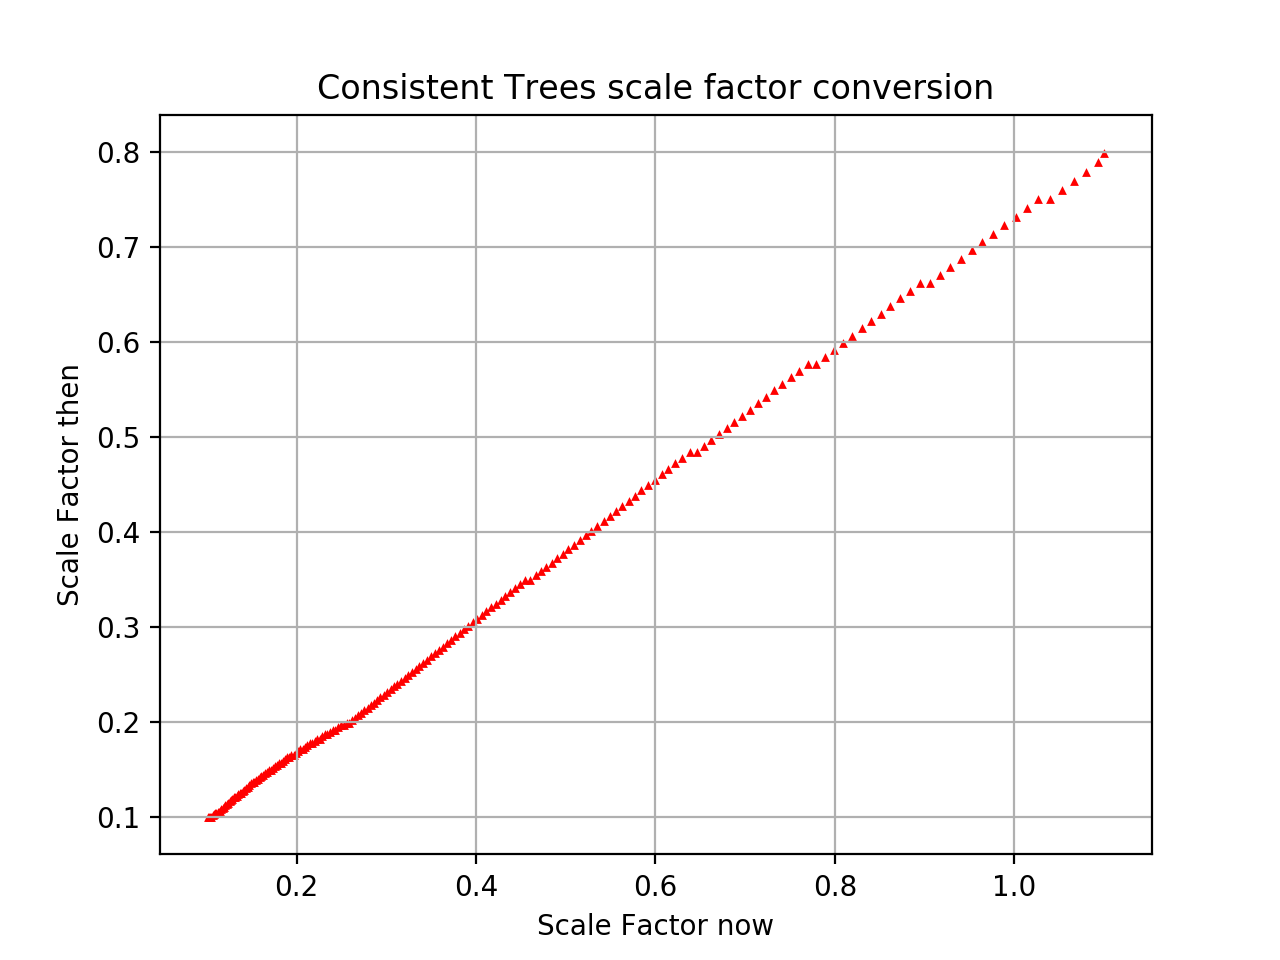

In [17]:
plt.figure()
plt.grid()
plt.scatter(sf_now_set, sf_then_set, marker = "^", s= 10, color = "red", linewidth = 0, alpha = 1.)
plt.xlabel("Scale Factor now")
plt.ylabel("Scale Factor then")
plt.title("Consistent Trees scale factor conversion")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/ct_sf_conversion.png")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/ct_sf_conversion.pdf")

In [11]:
# NOW COMPARE THIS TO WHAT BENEDIKT HAS 
from colossus.halo.mass_so import dynamicalTime
from colossus.cosmology import cosmology
from colossus.halo import mass_so

cosmo = cosmology.setCosmology('bolshoi')

sfthen_b = []

for sf in sf_now_set:
    
    znow= (1-sf)/sf
    # get the age at the given scale factor
    age_now = cosmo.age(znow, inverse = False)#  +(times_set[0]-time_b[0])/1e9
    
    # get the dynamical time here as well 
    dyntime = dynamicalTime(znow, "200m", definition='crossing') # dynamical time at our redshift 
    
    # get age one dynamical time ago
    age_then = age_now-dyntime
    
    # convert this to scale factor 
    zthen = cosmo.age(age_then, inverse = True)
    
    sfthen_exact = 1/(1.+zthen)
    
    # get the closest scale factor that agrees with the snapshot list 
    idx = np.argmin(abs(sf_now_set-sfthen_exact))
    
    sfthen_b.append(sf_now_set[idx])

<IPython.core.display.Javascript object>


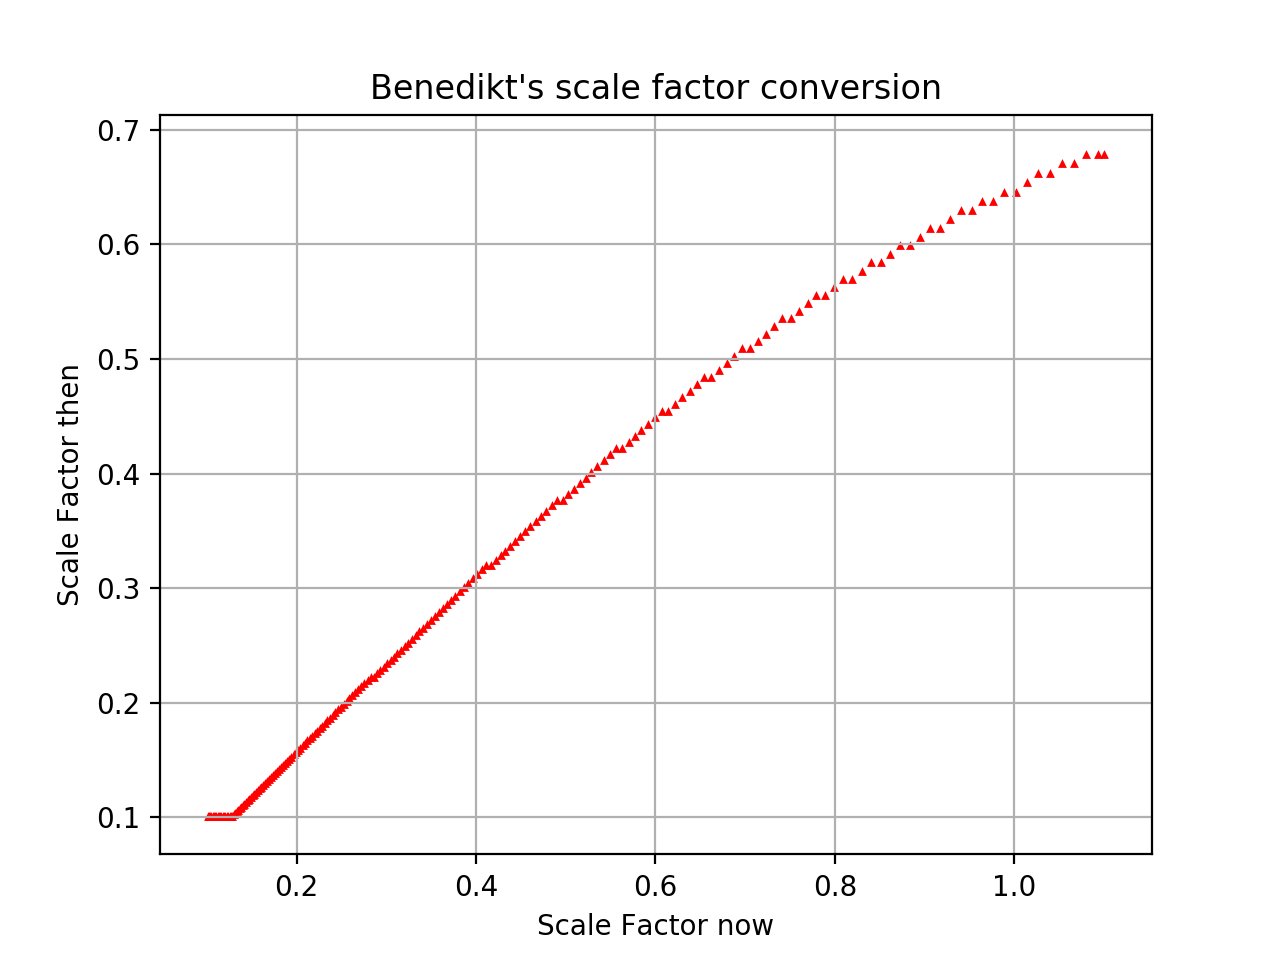

In [18]:
plt.figure()
plt.grid()
plt.scatter(sf_now_set, sfthen_b, marker = "^", s= 10, color = "red", linewidth = 0, alpha = 1.)
plt.xlabel("Scale Factor now")
plt.ylabel("Scale Factor then")
plt.title("Benedikt's scale factor conversion")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/benedikt_sf_conversion.png")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/benedikt_sf_conversion.pdf")

<IPython.core.display.Javascript object>


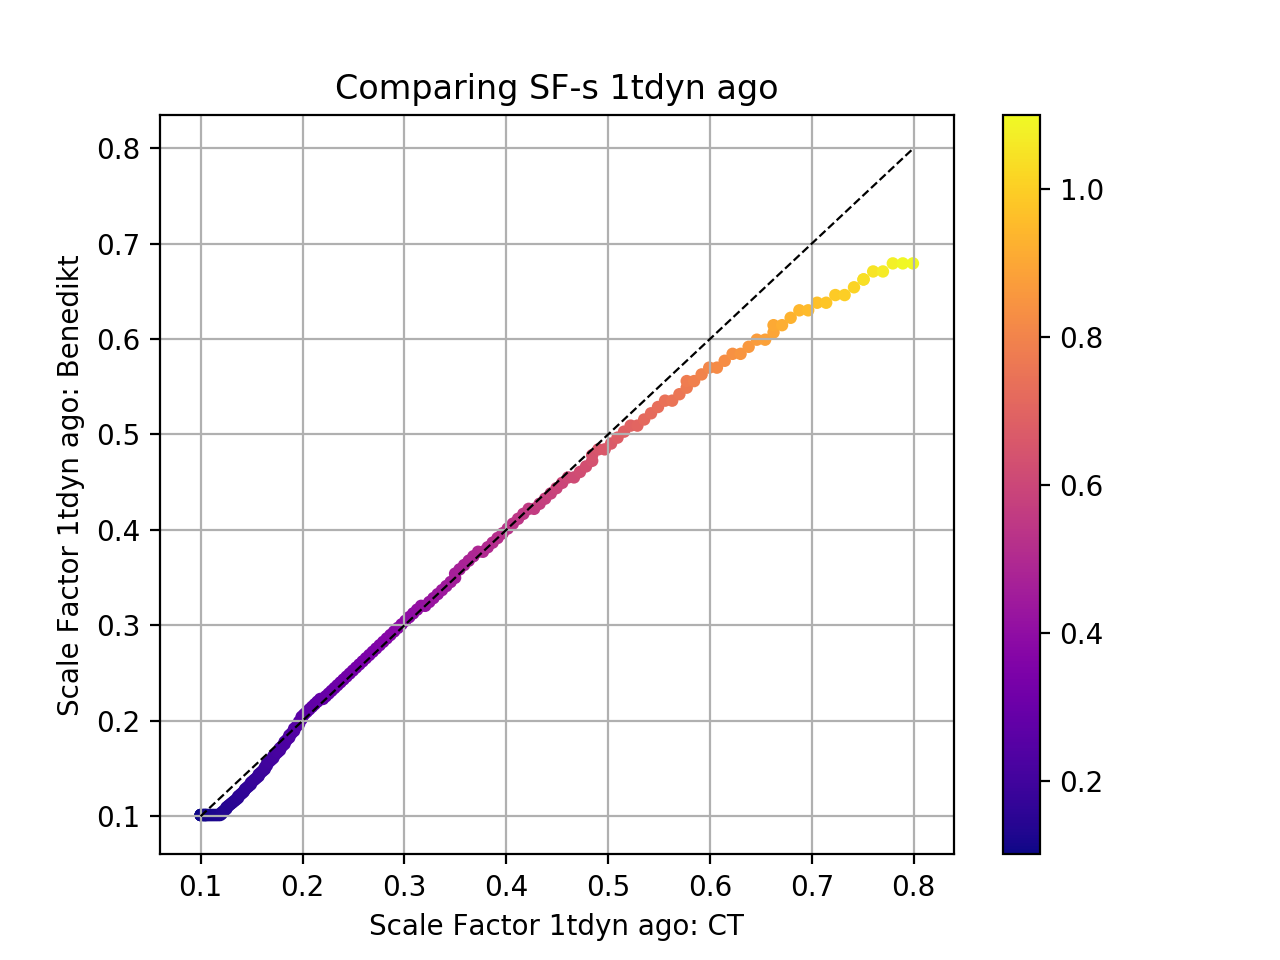

In [19]:
# Now putting everything together 

plt.figure()
plt.grid()
plt.scatter(sf_then_set, sfthen_b, marker = "o", s= 20, c = sf_now_set, linewidth = 0, alpha = 1., cmap='plasma')
plt.plot(sf_then_set, sf_then_set, "k--", linewidth = .8)
plt.xlabel("Scale Factor 1tdyn ago: CT")
plt.ylabel("Scale Factor 1tdyn ago: Benedikt")
plt.title("Comparing SF-s 1tdyn ago")
plt.colorbar()
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/sfthen_benedikt_ct.png")
plt.savefig("/Users/eniaxhakaj/Dropbox/Plots/sfthen_benedikt_ct.pdf")



## The issue might be in the dynamical time 